In [1]:
import numpy as np
from scipy import pi
import matplotlib.pyplot as plt
import pickle as cPickle
# #Sine wave

# N = 128

# def get_sine_wave():
#     x_sin = np.array([0.0 for i in range(N)])
#     # print(x_sin)
#     for i in range(N):
#         # print("h")
#         x_sin[i] = np.sin(2.0*pi*i/16.0)

#     plt.plot(x_sin)
#     plt.title('Sine wave')
#     plt.show()

#     y_sin = np.fft.fftshift(np.fft.fft(x_sin[:16], 16))
#     plt.plot(abs(y_sin))
#     plt.title('FFT sine wave')
#     plt.show()

#     return x_sin

# def get_bpsk_carrier():
#     x = np.fromfile('gnuradio_dumps/bpsk_carrier', dtype = 'float32')
#     x_bpsk_carrier = x[9000:9000+N]
#     plt.plot(x_bpsk_carrier)
#     plt.title('BPSK carrier')
#     plt.show()
    
#     y_bpsk_carrier =  np.fft.fft(x_bpsk_carrier, N)
#     plt.plot(abs(y_bpsk_carrier))
#     plt.title('FFT BPSK carrier')
#     plt.show()
    
#     return x_bpsk_carrier


# def get_qpsk_carrier():
#     x = np.fromfile('gnuradio_dumps/qpsk_carrier', dtype = 'float32')
#     x_qpsk_carrier = x[12000:12000+N]
#     plt.plot(x_qpsk_carrier)
#     plt.title('QPSK carrier')
#     plt.show()


#     # y_qpsk_carrier =  np.fft.fft(x_qpsk_carrier, N)
#     # plt.plot(abs(y_qpsk_carrier))
#     # plt.title('FFT QPSK carrier')
#     # plt.show()
    
#     return x_qpsk_carrier

# def get_bpsk():
#     x = np.fromfile('gnuradio_dumps/bpsk', dtype = 'complex64')
#     x_bpsk = x[9000:9000+N]
#     plt.plot(x_bpsk.real)
#     plt.plot(x_bpsk.imag)
#     plt.title('BPSK')
#     plt.show()



#     # y_bpsk =  np.fft.fft(x_bpsk, N)
#     # plt.plot(abs(y_bpsk))
#     # plt.title('FFT BPSK')
#     # plt.show()
    
#     return x_bpsk

# def get_qpsk():
#     x = np.fromfile('gnuradio_dumps/qpsk', dtype = 'complex64')
#     x_qpsk = x[11000:11000+N]
#     plt.plot(x_qpsk.real)
#     plt.plot(x_qpsk.imag)
#     plt.title('QPSK')
#     plt.show()



#     # y_qpsk =  np.fft.fft(x_bpsk, N)
#     # plt.plot(abs(y_bqsk))
#     # plt.title('FFT QPSK')
#     # plt.show()
    
#     return x_qpsk

def load_dataset(location="../../datasets/radioml.dat"):
    f = open(location, "rb")
    ds = cPickle.load(f, encoding = 'latin-1')
    return ds


# def get_from_dataset(dataset, key):
#     """Returns complex version of dataset[key][500]"""
#     xr = dataset[key][500][0]
#     xi = dataset[key][500][1]
#     plt.plot(xr)
#     plt.plot(xi)
#     plt.title(key)
#     plt.show()
#     return xr+1j*xi

# x_sin = get_sine_wave()
# x_bpsk_carrier = get_bpsk_carrier()
# x_qpsk_carrier = get_qpsk_carrier()
# x_bpsk = get_bpsk()
# x_qpsk = get_qpsk()

# ds = load_dataset(location="../modulation_recognition/RML2016.10a_dict.dat")
# x_amssb = get_from_dataset(dataset=ds, key=('AM-SSB', 0))
# x_amdsb = get_from_dataset(dataset=ds, key= ('AM-DSB', 0))
# x_gfsk = get_from_dataset(dataset=ds, key=('GFSK', 0))
# x_bpsk_dataset = get_from_dataset(dataset=ds, key = ('BPSK',18))
# x_qpsk_dataset = get_from_dataset(dataset=ds, key = ('QPSK',0))



In [2]:
nfft = 16
cyclo_averaging = 8
offsets = [0,1,2,3,4,5,6,7]
zero_threshold = 1e-3

def round_to_zero(data, zero_threshold):
    '''Set entries with absolute values below threshold to zero'''
    data_rounded = data
    for k,s in enumerate(data):
        if abs(s) < zero_threshold:
            data_rounded[k] = 0
    return data_rounded
    
def compute_cyclo_fft(data, nfft):  
    '''
    Split data into blocks of size nfft and compute fft for each block       
    Input:data: length N (say), 
          nfft: size of fft
    Output: nfft x N/nfft size matrix where jth column contains fft of jth block
    '''

    data_reshape = np.reshape(data, (-1, nfft))    
    y =  np.fft.fftshift(np.fft.fft(data_reshape, axis=1), axes=1)  
#     plt.plot(data_reshape[0,:].real)
#     plt.title('Sample Data ' + str(nfft) + ' points')
#     plt.show()
    return y.T


def compute_correlation(x,y):
    '''
    Input: x and y are arrays to be correlated
    Output: inner product of x and y divided by length of x'''
    x = np.reshape(x, [-1,])
    y = np.reshape(y, [-1,])
    lenx = x.shape[0]
    corr = 0
    for i in range(lenx):
        corr += x[i]*np.conj(y[i])        
    corr /= lenx
    return corr

def compute_coefficients(cyc_fft, alphas):
    '''
    Input:nfft X cyclo_averaging size matrix where jth column is fft of a sample
    Output:specs: nfft X num_offsets size matrix where jth column contains spectral coefficients corresponding to its alpha(offset)
           scs: nfft X num_offsets size matrix where jth column contains scaled spectral coefficients corresponding to its alpha(offset)
    The spectral coefficients close to 0 are set to exactly zero before scaling to obtain scs
    '''       

    specs = np.zeros((nfft,len(alphas)), dtype=np.complex)
    scs = np.zeros((nfft,len(alphas)),dtype=np.complex)
    for alpha in alphas:
        z = np.array(np.zeros(cyc_fft.shape), dtype=np.complex)
        denom_right = np.zeros(cyc_fft.shape, dtype=np.complex)
        denom_left = np.zeros(cyc_fft.shape,dtype=np.complex)        
        for i in range(cyc_fft.shape[1]):
            x = cyc_fft[:,i]
            x_right = np.roll(x, alpha)
            x_left = np.roll(x, -alpha)
            z[:,i] = (x_right*np.conj(x_left))/cyc_fft.shape[1]                        
            
            denom_right[:,i] =(x_right*np.conj(x_right)/cyc_fft.shape[1])
            denom_left[:,i] = (x_left*np.conj(x_left)/cyc_fft.shape[1])            
            spec = np.mean(z,axis=1)   
            denom = np.sqrt(np.abs(np.mean(denom_right, axis=1))*np.abs(np.mean(denom_left,axis=1)))
           
            specs[:,alpha] = spec
            spec = round_to_zero(spec, zero_threshold)           
            sc = spec/denom
            scs[:,alpha] = sc 
            
    return specs, scs

def cyclo_stationary(data):
    cyc_fft = compute_cyclo_fft(data, nfft)  
    specs, scs = compute_coefficients(cyc_fft,alphas = offsets)
    return specs, scs    

def convert_to_1d(data_2d):
    '''Stacks columns below each other'''
    M,N= data_2d.shape
    data_1d = np.zeros((M*N,),dtype=np.complex)
    for i in range(N):
        data_1d[i*M:(i+1)*M] = data_2d[:,i]        
    return data_1d

# def visualize_2d(data_list, key_list, title, alphas, group='key'):  
#     '''
#     If group is 'key' for each alpha plot specs for all keys in one plot
#     If group is 'alpha' for each key plot specs for all alphas in one plot
#     '''
#     if group == 'key':
#         for alpha in alphas:
#             for k,data in enumerate(data_list):
#                 key = key_list[k]
#                 plt.plot(abs(data[:,alpha]), 'o--', label = key)            
#             plt.title(title+', Alpha:' + str(alpha))        
#             plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#             plt.xlabel('f/fs')
#             plt.ylabel('alpha/fs')
#             plt.show() 
#     elif group == 'alpha':
#         for k,key in enumerate(key_list):
#             data = data_list[k]
#             for alpha in alphas:
#                 plt.plot(abs(data[:,alpha]), 'o--', label='Alpha:' +str(alpha))
#             plt.title(title + ', Key: ' + str(key))
#             plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#             plt.xlabel('f/fs')
#             plt.ylabel('alpha/fs')
#             plt.show() 

# def visualize_1d(data_list, key_list, title):
#     for k,data in enumerate(data_list):
#         key = key_list[k]        
#         plt.plot(abs(data), 'x--', label = str(key))
#     plt.title(title)    
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.show()


# #Dataset QPSk
# specs_2d_qpsk_real,scs_2d_qpsk_real = cyclo_stationary(x_qpsk_dataset.real)
# specs_1d_qpsk_real = convert_to_1d(specs_2d_qpsk_real)
# specs_2d_qpsk_imag,scs_2d_qpsk_imag = cyclo_stationary(x_qpsk_dataset.imag)
# specs_1d_qpsk_imag= convert_to_1d(specs_2d_qpsk_imag)
# visualize_1d(data_list=[specs_1d_qpsk_real, specs_1d_qpsk_imag], key_list=["Real('QPSK',18)", "Imag('QPSK',18)" ], title='Specs(Magnitude)')

# #Dataset BPSK
# specs_2d_bpsk_real,scs_2d_bpsk_real = cyclo_stationary(x_bpsk_dataset.real)
# specs_1d_bpsk_real = convert_to_1d(specs_2d_bpsk_real)
# specs_2d_bpsk_imag,scs_2d_bpsk_imag = cyclo_stationary(x_bpsk_dataset.imag)
# specs_1d_bpsk_imag= convert_to_1d(specs_2d_bpsk_imag)
# visualize_1d(data_list=[specs_1d_bpsk_real, specs_1d_bpsk_imag],  key_list=["Real('BPSK',18)", "Imag('BPSK',18)" ],  title='Specs(Magnitude)')


# #BPSK,QPSK at carrier
# specs_2d_bpsk_carrier,scs_2d_bpsk_carrier = cyclo_stationary(x_bpsk_carrier)
# specs_1d_bpsk_carrier = convert_to_1d(specs_2d_bpsk_carrier)
# specs_2d_qpsk_carrier,scs_2d_qpsk_carrier = cyclo_stationary(x_qpsk_carrier)
# specs_1d_qpsk_carrier = convert_to_1d(specs_2d_qpsk_carrier)
# visualize_1d(data_list=[specs_1d_qpsk_carrier, specs_1d_bpsk_carrier], key_list=["QPSK carrier", "BPSK carrier"], title = 'Specs(Magnitude)')
# visualize_2d(data_list = [specs_2d_qpsk_carrier, specs_2d_bpsk_carrier], key_list=["QPSK carrier", "BPSK_carrier"], title = 'Specs(Magnitude)', alphas = offsets, group = 'key')
# visualize_2d(data_list = [specs_2d_qpsk_carrier, specs_2d_bpsk_carrier ],  key_list=["QPSK carrier", "BPSK carrier"], title = 'Specs(Magnitude)', alphas = offsets, group = 'alpha')

# #Sine wave
# specs_2d_sin,scs_2d_sin = cyclo_stationary(x_sin.real)
# specs_1d_sin = convert_to_1d(specs_2d_sin)
# visualize_1d(data_list=[specs_1d_sin],  key_list=["Sin" ],  title='Specs(Magnitude)')
# visualize_2d(data_list = [specs_2d_sin], key_list=["Sin"], title = 'Specs(Magnitude)', alphas = offsets, group = 'key')
# visualize_2d(data_list = [specs_2d_sin], key_list=["Sin"], title = 'Specs(Magnitude)', alphas = offsets, group = 'alpha')


<h1> Classification onwards from here </h1>

In [3]:
from sklearn import svm

In [4]:
ds = load_dataset(location="../../datasets/radioml.dat")
# bpsk_18 = ds[("BPSK", 18)]
# qpsk_18 = ds[("QPSK", 18)]
# classes = {"bpsk": 0, "qpsk": 1}

In [5]:
from tqdm import tqdm

def wrapper_cyclo(data):
    """Presumes data is n datapoints."""
    n, _ = data.shape
    specs = np.zeros((n, 128), dtype = 'complex')
    for i in tqdm(range(n)):
#     for i in range(n):
        a, _ = cyclo_stationary(data[i, :])
        specs[i, :] = convert_to_1d(a)
#         print(specs[0])
    return specs

In [6]:
# snr_vals = list(map(lambda a: a[1], list(filter(lambda a:a[0] == 'BPSK' and a[1] != 18, list(ds.keys()), ))))
# snr_vals = [16,14, 12, 10, 8, 6]
# bpsk = ds[("BPSK", 18)]
# qpsk = ds[("QPSK", 18)]
# for i in snr_vals:
#     bpsk = np.vstack([ds[("BPSK", i)], bpsk])
#     qpsk = np.vstack([ds[("QPSK", i)], qpsk])
# bpsk = np.add(bpsk[:, 0, :], 1j*bpsk[:, 1, :])
# qpsk = np.add(qpsk[:, 0, :], 1j*qpsk[:, 1, :])
# bpsk_features = wrapper_cyclo(bpsk)
# qpsk_features = wrapper_cyclo(qpsk)

In [46]:
# def create_train_test(data1, data2, shuffle=False):
#     training_set = 0.7
#     n1, _ = data1.shape
#     n2, _ = data2.shape
#     num_train_1 = int(n1 * training_set)
#     num_train_2 = int(n2 * training_set)

#     if shuffle:
#         np.random.shuffle(data1)
#         np.random.shuffle(data2)

#     train_q = data1[:num_train_1, ]
#     train_b = data2[:num_train_2, ]
#     test_q = data1[num_train_1:, ]
#     test_b = data2[num_train_2:, ]

#     train_x = np.vstack((train_q, train_b))
#     train_y = np.vstack((np.zeros((num_train_1, 1)), np.ones((num_train_2, 1)))) # data1 - 0, data2 - 1

#     test_x = np.vstack((test_q, test_b))
#     test_y = np.vstack((np.zeros((n1 - num_train_1, 1)), np.ones((n2 - num_train_2, 1))))

#     # Time to mix the data
#     together = np.hstack((train_x, train_y))
#     if shuffle:
#         np.random.shuffle(together)
        
#     train_x, train_y = np.hsplit(together, [together.shape[1] - 1])

#     together = np.hstack((test_x, test_y))
    
#     if shuffle:
#         np.random.shuffle(together)
    
#     test_x, test_y = np.hsplit(together, [together.shape[1] - 1])
#     return train_x, train_y, test_x, test_y
# def percentage_success(actual, predicted):
#     return 1 - (np.linalg.norm(actual - predicted)**2 / (predicted.shape[0]))

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

def gamut_classification(train_x, train_y, test_x, test_y):
    train_y = train_y.reshape([-1,])
    clf = SVC(C = 1.0, kernel='poly')
    clf.fit(train_x, train_y )
    predicted = clf.predict(test_x).reshape((-1, 1))
    print("Polynomial Kernel, SVM ", percentage_success(test_y, predicted))
    clf = SVC(C = 1.0, kernel='rbf')
    clf.fit(train_x, train_y)
    predicted = clf.predict(test_x).reshape((-1, 1))
    print("RBF Kernel, SVM ", percentage_success(test_y, predicted))
    clf = SVC(C = 1.0, kernel='linear')
    clf.fit(train_x, train_y)
    predicted = clf.predict(test_x).reshape((-1, 1))
    print("Linear Kernel, SVM ", percentage_success(test_y, predicted))
    clf = RandomForestClassifier(max_depth=2, n_estimators=100)
    clf.fit(train_x, train_y)
    predicted = clf.predict(test_x).reshape((-1, 1))
    print("Random Forests ", percentage_success(test_y, predicted))
    clf = AdaBoostClassifier(n_estimators=100)
    clf.fit(train_x, train_y)
    predicted = clf.predict(test_x).reshape((-1, 1))
    print("AdaBoost ", percentage_success(test_y, predicted))

In [8]:
# train_x, train_y, test_x, test_y = create_train_test(bpsk_features, qpsk_features)

# train_x_real_imag = np.hstack([train_x.real, train_x.imag])
# test_x_real_imag = np.hstack([test_x.real, test_x.imag])

# train_x_mag_phase = np.hstack([np.abs(train_x), np.angle(train_x)])
# test_x_mag_phase = np.hstack([np.abs(test_x), np.angle(test_x)])


# print("Using real imaginary")
# gamut_classification(train_x_real_imag, train_y, test_x_real_imag, test_y)
# print("")
# print("Using mag phase")
# gamut_classification(train_x_mag_phase, train_y, test_x_mag_phase, test_y)

# # print("")
# print("Real only")
# gamut_classification(train_x, train_y, test_x, test_y)

# We have the following results for QPSK vs BPSK snrs upto 6:
# Using real imaginary
# Polynomial Kernel, SVM  0.5
# RBF Kernel, SVM  0.500714285714
# Linear Kernel, SVM  0.499285714286
# Random Forests  0.697857142857
# AdaBoost  0.855

# Using mag phase
# Polynomial Kernel, SVM  0.723095238095
# RBF Kernel, SVM  0.722142857143
# Linear Kernel, SVM  0.567619047619
# Random Forests  0.770476190476
# AdaBoost  0.848333333333


In [9]:
# Normalization functions
def normalize(data):
    # Normalizes the norm of the entire vector to 1
    data = data.copy()
    n, _  = data.shape
    if n == 1:
        return singular_normalize(data)
    
    for i in range(n):
        data[i, :] = singular_normalize(data[i, :])
        
    return data
    
def singular_normalize(data_vector):
    # Normalizes one vector to 1
    norm = np.linalg.norm(data_vector)
    return data_vector / norm

# Let us generate AWGN, unit variance, normalize, and compare classification

In [10]:
# awgn_data = normalize(np.random.normal(0, 1, (bpsk_features.shape[0], 128)))
# bpsk_features_norm = normalize(bpsk_features)
# awgn_features = wrapper_cyclo(awgn_data)

In [11]:
# train_x, train_y, test_x, test_y = create_train_test(bpsk_features_norm, awgn_features)

# train_x_real_imag = np.hstack([train_x.real, train_x.imag])
# test_x_real_imag = np.hstack([test_x.real, test_x.imag])

# train_x_mag_phase = np.hstack([np.abs(train_x), np.angle(train_x)])
# test_x_mag_phase = np.hstack([np.abs(test_x), np.angle(test_x)])


# print("Using real imaginary")
# gamut_classification(train_x_real_imag, train_y, test_x_real_imag, test_y)
# print("")
# print("Using mag phase")
# gamut_classification(train_x_mag_phase, train_y, test_x_mag_phase, test_y)


### We conclude that the classifiers can baseline classify high SNR BPSK vs AWGN. Now we proceed to work with much extended datasets to classify BPSK vs QPSK. These are the ones with the most similar peaks.

In [12]:
# def load_dataset(dat_file):
#     """Input: path to .dat binary data file
#        Outputs:
#        dataset: The dataset loaded by cPickle
#        X: [num_samples, 2, vec_length=128] size 3D array. X[i][0][:] is the real part, X[i][1][:] is the imaginary part
#        uid_list: [num_samples] length list. Contains the 'uid' for each sample which can be used to find its label using lbl_map
#        lbl_map: Dictionary containing labels for a uid
#        lbl: [num_samples] length list. Contains the list of dictionary labels
#        """
#     f = open(dat_file, 'rb')
#     dataset = cPickle.load(f, encoding = 'latin-1')
    
#     Xd = dataset['samples']
#     lbl_map = dataset['uid_map']
#     total_ids = dataset['total_uids']
#     lbl = []
#     X = []
#     uid_list = []
#     for uid in Xd:
#         X.append(Xd[uid])
#         for j in range(Xd[uid].shape[0]):
#             lbl.append((lbl_map[uid]))
#             uid_list.append(uid)
#     X = np.vstack(X)
#     return [dataset, X, uid_list, lbl_map, lbl]

# def is_match(target_dict, cand_dict):
#     """Check if all the key-value pairs in target_dict are present in cand_dict"""
#     for key in target_dict:
#         if key != 'channel_model':
#             if key not in cand_dict:       
#                 return False
#             else:
#                 got_key = False
#                 for inkey in target_dict[key]:  
#                     if inkey == cand_dict[key]:
#                         got_key = True
#                         break
                
#                 if got_key is False:
#                     return False
#         else:
#             # print key
#             # print cand_dict
#             if 'channel_model' not in cand_dict:
#                 return False
#             else:
#                 cand_channel_dict = cand_dict['channel_model']
#                 if cand_channel_dict['channel_type'] != target_dict[key]:
#                     return False
#     return True


# def assemble_samples(X):
#     '''Assemble to desired format containing complex numbers'''
#     Y  = np.zeros((X.shape[0], X[0].shape[1]), dtype = 'complex')
#     for i in range(X.shape[0]):
#         Y[i,:] = X[i][0][:] + 1j*X[i][1][:]
#     return Y
    
# def get_samples(target_dict, dataset):
#     X = np.zeros((0,0))
#     for uid in dataset['samples']:
#         cur_dict = dataset['uid_map'][uid]
      
#         if is_match(target_dict, cur_dict):
#             if X.shape[0] == 0:
#                 X= assemble_samples(dataset['samples'][uid])
#             else:
#                 Y = assemble_samples(dataset['samples'][uid])
#                 X = np.vstack([X, Y])
            
#     return X
            

In [13]:
# dat_file = '../../datasets/basic.dat'
# [dataset, X, uid_list, lbl_map, lbl] = load_dataset(dat_file)

In [14]:
# target_dict_bpsk = {}
# target_dict_bpsk['mod_type'] = [ 'BPSK_G']


# target_dict_qpsk = {}
# target_dict_qpsk['mod_type'] = [ 'QPSK_G']


In [15]:
# bpsk_128 = get_samples(target_dict_bpsk, dataset)
# qpsk_128 = get_samples(target_dict_qpsk, dataset)


In [16]:

# plt.plot(bpsk_128.real[500])
# plt.plot(bpsk_128.imag[500])
# plt.title("BPSK")
# plt.show()
# plt.clf()
# plt.plot(qpsk_128.imag[500])
# plt.plot(qpsk_128.real[500])
# plt.title("QPSK")
# plt.show()

### We now have two arrays of split signals, each split snippet is 128 samples long. We now calculate the cyclostationary coefficients of these signals, and then run a gamut of classification techniques to see what works.

In [17]:
# N = 10000
# offset = 1000
# print(bpsk_128.shape)
# print(qpsk_128.shape)
# bpsk_features = wrapper_cyclo(bpsk_128)
# qpsk_features = wrapper_cyclo(qpsk_128)



In [18]:
# train_x, train_y, test_x, test_y = create_train_test(bpsk_features, qpsk_features)
# print("Done Creating Training and test set.")

In [19]:
# train_x_real_imag = np.hstack([train_x.real, train_x.imag])
# test_x_real_imag = np.hstack([test_x.real, test_x.imag])

# train_x_mag_phase = np.hstack([np.abs(train_x), np.angle(train_x)])
# test_x_mag_phase = np.hstack([np.abs(test_x), np.angle(test_x)])


# print("Using real imaginary")
# gamut_classification(train_x_real_imag, train_y, test_x_real_imag, test_y)
# print("")
# print("Using mag phase")
# gamut_classification(train_x_mag_phase, train_y, test_x_mag_phase, test_y)

# gamut_classification(train_x, train_y, test_x, test_y)

''' Using real imaginary 
Polynomial Kernel, SVM  0.5
RBF Kernel, SVM  0.5
Linear Kernel, SVM  0.575166666667
Random Forests  0.887166666667
AdaBoost  0.922166666667

Using mag phase
Polynomial Kernel, SVM  0.876
RBF Kernel, SVM  0.874
Linear Kernel, SVM  0.660833333333
Random Forests  0.770333333333
AdaBoost  1.0 '''


In [20]:
from sklearn.decomposition import PCA, NMF
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

def gamut_classification_pca(X, Y, n_features=[16,32,64,128],
                            c_options=[1, 10, 100, 1000], n_estimators=[10, 100, 1000],use_svm=True,use_adaboost=True,
                            use_k_neighbors=True):
    """
    Depending on passed in Arguments, does dimensionality reduction and then classifies.
    """
    pipe = Pipeline([
        ('reduce_dim', PCA()),
        ('classify', SVC())
    ])
    
    param_grid = []
    
    if use_adaboost:
        param_grid.append({
            'reduce_dim': [PCA(iterated_power=7)],
            'reduce_dim__n_components': n_features,
            'classify': [AdaBoostClassifier()],
            'classify__n_estimators': n_estimators
        })
    
    if use_svm:
        param_grid.append({
            'reduce_dim': [PCA(iterated_power=7)],
            'reduce_dim__n_components': n_features,
            'classify': [SVC()],
            'classify__C': c_options
        })
        
    if use_k_neighbors:
        param_grid.append({
            'reduce_dim': [PCA(iterated_power=7)],
            'reduce_dim__n_components': n_features,
            'classify': [SVC()],
            'classify__C': c_options
        })
        
        
    grid = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid, verbose=10)
    grid.fit(X, Y)
    return grid
    

In [21]:
# N = 100
# offset = 1000
# bpsk_features_100 = wrapper_cyclo(bpsk_128[offset: offset + N, :])
# qpsk_features_100 = wrapper_cyclo(qpsk_128[offset: offset + N, :])
# train_x, train_y, test_x, test_y = create_train_test(bpsk_features_100, qpsk_features_100)

In [22]:
# train_x_real_imag = np.hstack([train_x.real, train_x.imag])
# test_x_real_imag = np.hstack([test_x.real, test_x.imag])

# train_x_mag_phase = np.hstack([np.abs(train_x), np.angle(train_x)])
# test_x_mag_phase = np.hstack([np.abs(test_x), np.angle(test_x)])

# X_real_imag = np.vstack([train_x_real_imag, test_x_real_imag])
# X_mag_phase = np.vstack([train_x_mag_phase, test_x_mag_phase])
# Y = np.vstack([train_y, test_y])

# grid_real_imag = gamut_classification_pca(X_real_imag, Y.ravel())
# grid_mag_phase = gamut_classification_pca(X_mag_phase, Y.ravel())

In [23]:
# print("Using real imag")
# print(grid_real_imag.best_estimator_)
# print(grid_real_imag.best_score_)

In [24]:
# print("Using mag phase")
# print(grid_mag_phase.best_estimator_)
# print(grid_mag_phase.best_score_)

In [25]:
# N = 1000
# offset = 1000
# bpsk_features_1000 = wrapper_cyclo(bpsk_128[offset: offset + N, :])
# qpsk_features_1000 = wrapper_cyclo(qpsk_128[offset: offset + N, :])
# train_x, train_y, test_x, test_y = create_train_test(bpsk_features_1000, qpsk_features_1000)

# train_x_real_imag = np.hstack([train_x.real, train_x.imag])
# test_x_real_imag = np.hstack([test_x.real, test_x.imag])

# train_x_mag_phase = np.hstack([np.abs(train_x), np.angle(train_x)])
# test_x_mag_phase = np.hstack([np.abs(test_x), np.angle(test_x)])

# X_real_imag = np.vstack([train_x_real_imag, test_x_real_imag])
# X_mag_phase = np.vstack([train_x_mag_phase, test_x_mag_phase])
# Y = np.vstack([train_y, test_y])

# grid_real_imag = gamut_classification_pca(X_real_imag, Y.ravel())
# grid_mag_phase = gamut_classification_pca(X_mag_phase, Y.ravel())

In [26]:
# print("Using real imag")
# print(grid_real_imag.best_estimator_)
# print(grid_real_imag.best_score_)

# print("Using mag phase")
# print(grid_mag_phase.best_estimator_)
# print(grid_mag_phase.best_score_)

In [27]:
# bpsk = ds[("BPSK", 18)]
# qpsk = ds[("QPSK", 18)]

# bpsk = np.add(bpsk[:, 0, :], 1j*bpsk[:, 1, :])
# qpsk = np.add(qpsk[:, 0, :], 1j*qpsk[:, 1, :])
# bpsk_features = wrapper_cyclo(bpsk)
# qpsk_features = wrapper_cyclo(qpsk)
# train_x, train_y, test_x, test_y = create_train_test(bpsk_features, qpsk_features)

# train_x_real_imag = np.hstack([train_x.real, train_x.imag])
# test_x_real_imag = np.hstack([test_x.real, test_x.imag])

# train_x_mag_phase = np.hstack([np.abs(train_x), np.angle(train_x)])
# test_x_mag_phase = np.hstack([np.abs(test_x), np.angle(test_x)])

# X_real_imag = np.vstack([train_x_real_imag, test_x_real_imag])
# X_mag_phase = np.vstack([train_x_mag_phase, test_x_mag_phase])
# Y = np.vstack([train_y, test_y])

# grid_real_imag = gamut_classification_pca(X_real_imag, Y.ravel())
# grid_mag_phase = gamut_classification_pca(X_mag_phase, Y.ravel())




In [28]:
# print("Using real imag")
# print(grid_real_imag.best_estimator_)
# print(grid_real_imag.best_score_)

# print("Using mag phase")
# print(grid_mag_phase.best_estimator_)
# print(grid_mag_phase.best_score_)

In [29]:
# # snr_vals = list(map(lambda a: a[1], list(filter(lambda a:a[0] == 'BPSK' and a[1] != 18, list(ds.keys()), ))))
# snr_vals = [16,14, 12, 10, 8, 6]

# bpsk = ds[("BPSK", 18)]
# qpsk = ds[("QPSK", 18)]
# for i in snr_vals:
#     bpsk = np.vstack([ds[("BPSK", i)], bpsk])
#     qpsk = np.vstack([ds[("QPSK", i)], qpsk])

# bpsk = np.add(bpsk[:, 0, :], 1j*bpsk[:, 1, :])
# qpsk = np.add(qpsk[:, 0, :], 1j*qpsk[:, 1, :])
# bpsk_features = wrapper_cyclo(bpsk)
# qpsk_features = wrapper_cyclo(qpsk)
# train_x, train_y, test_x, test_y = create_train_test(bpsk_features, qpsk_features)

# train_x_real_imag = np.hstack([train_x.real, train_x.imag])
# test_x_real_imag = np.hstack([test_x.real, test_x.imag])

# train_x_mag_phase = np.hstack([np.abs(train_x), np.angle(train_x)])
# test_x_mag_phase = np.hstack([np.abs(test_x), np.angle(test_x)])

# X_real_imag = np.vstack([train_x_real_imag, test_x_real_imag])
# X_mag_phase = np.vstack([train_x_mag_phase, test_x_mag_phase])
# Y = np.vstack([train_y, test_y])

# grid_real_imag = gamut_classification_pca(X_real_imag, Y.ravel())
# grid_mag_phase = gamut_classification_pca(X_mag_phase, Y.ravel())


In [30]:
# print("Using real imag")
# print(grid_real_imag.best_estimator_)
# print(grid_real_imag.best_score_)

# print("Using mag phase")
# print(grid_mag_phase.best_estimator_)
# print(grid_mag_phase.best_score_)

### We have that using all SNRs lowers effectiveness by 20% for BPSK vs QPSK, instead of just SNR 18.
## Let us now use AdaBoost with PCA onto 32/64 dimensions and generate a confusion matrix for all signals with SNR 18

In [31]:
def create_labels(data, shuffle=False):
    """
    Takes an array of n data arrays and assign labels of i for elements in array i.
    """
    ys = [np.zeros((arr.shape[0], 1)) + i for i, arr in enumerate(data)]
    X = np.vstack(data)
    Y = np.vstack(ys)
    print(X.shape, Y.shape)

    # Time to mix the data
    if shuffle:
        together = np.hstack((X, Y))
        np.random.shuffle(together)
        X, Y = np.hsplit(together, [together.shape[1] - 1])

    return X, Y

In [32]:
data = [(key, value) for key, value in ds.items() if key[1] == 18]
labels, data_signal = zip(*data)
signals = list(
    map(lambda data: data[:, 0, :] + 1j*data[:, 1, :], data_signal)
) # Convert into a complex number from I and Q

In [33]:
# X, Y = create_labels(signals)

In [34]:
# X_real_imag = np.hstack([X.real, X.imag])

# X_mag_phase = np.hstack([np.abs(X), np.angle(X)])



In [35]:
# grid_real_imag = gamut_classification_pca(X_real_imag, Y.ravel(), use_svm=False, n_estimators=[100], n_features=[32, 64, 128, 256])

In [36]:
# grid_real_imag.best_estimator_

In [37]:
from sklearn.metrics import confusion_matrix
# clf_real_imag = grid_real_imag.best_estimator_
# true_y, pred_y = Y, clf_real_imag.predict(X)from sklearn.metrics import confusion_matrix
# clf_real_imag = grid_real_imag.best_estimator_
# true_y, pred_y = Y, clf_real_imag.predict(X)

In [38]:
import itertools
# import numpy as np
# import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# # Compute confusion matrix
# cnf_matrix = confusion_matrix(true_y, pred_y)
# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=labels,
#                       title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True,
#                       title='Normalized confusion matrix')

# plt.show()

In [39]:
# cyclo_coeffs = list(map(wrapper_cyclo, signals))

In [40]:
# X, Y = create_labels(np.stack((signals, cyclo_coeffs)))


# X, Y = create_labels(cyclo_coeffs)
# X_real_imag = np.hstack([X.real, X.imag])



# grid_real_imag = gamut_classification_pca(X_real_imag, Y.ravel(), use_svm=False, n_estimators=[100], n_features=[32, 64, 128])


In [41]:
# print(grid_real_imag.best_estimator_)
# print(grid_real_imag.best_score_)


In [42]:
# clf = grid_real_imag.best_estimator_
# true_y, pred_y = Y.ravel(), clf.predict(X_real_imag).ravel()
# # Compute confusion matrix
# cnf_matrix = confusion_matrix(true_y, pred_y)
# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure(figsize=(10, 20))
# plot_confusion_matrix(cnf_matrix, classes=labels,
#                       title='Confusion matrix, without normalization')
# plt.show()

# # Plot normalized confusion matrix
# plt.figure(figsize=(10, 20))
# plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True,
#                       title='Normalized confusion matrix')

# plt.show()

In [43]:
data = [(key, value) for key, value in ds.items() if key[1] >= 6]
# labels, data_signal = zip(*data)
# signals = list(
#     map(lambda data: data[:, 0, :] + 1j*data[:, 1, :], data_signal)
# ) # Convert into a complex number from I and Q

signals = []
unique_keys = []
for key in data:
    if key[0][0] not in unique_keys:
        unique_keys.append(key[0][0])
for unique_key in unique_keys:
    X = np.zeros((0,0), dtype = 'complex')        

    for s in data:
        if s[0][0] == unique_key:
#             print(s[0][0])
            if X.shape[0] == 0:
                X = s[1][:,0] + 1j*s[1][:,1]
            else:                
                Y =  s[1][:,0] + 1j*s[1][:,1]
#                 print(Y.shape)
                X = np.vstack([X, Y])
#     print(X.shape)
    signals.append(X)
        
            
        
cyclo_coeffs = list(map(wrapper_cyclo, signals))


100%|██████████| 7000/7000 [00:34<00:00, 205.86it/s]


(77000, 128) (77000, 1)


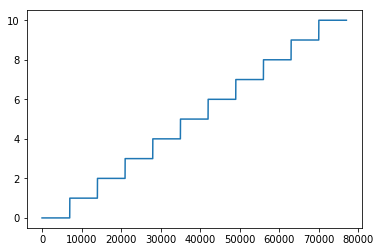

In [44]:
def create_labels(data, shuffle=False):
    """
    Takes an array of n data arrays and assign labels of i for elements in array i.
    """
    ys = [np.zeros((arr.shape[0], 1)) + i for i, arr in enumerate(data)]
    X = np.vstack(data)
    Y = np.vstack(ys)
    print(X.shape, Y.shape)

    # Time to mix the data
    if shuffle:
        together = np.hstack((X, Y))
        np.random.shuffle(together)
        X, Y = np.hsplit(together, [together.shape[1] - 1])

    return X, Y

X, Y = create_labels(cyclo_coeffs)
# Xs, Y = create_labels(signals)

X_mag_phase = np.hstack([np.abs(X), np.angle(X)])

# X_mag_phase = np.hstack([np.abs(X), np.angle(X), np.abs(Xs), np.angle(Xs)])
# print(X_mag_phase.shape)

plt.plot(Y)
plt.show()


In [47]:
grid_mag_phase = gamut_classification_pca(X_mag_phase, Y.ravel(), use_svm=False, n_estimators=[100], n_features=[32, 64, 128])


Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=32 
[CV]  classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=32, score=0.19992989016125262, total=  22.2s
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=Non

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.8s remaining:    0.0s


[CV]  classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=32, score=0.19409266258816193, total=  21.8s
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=32 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.2s remaining:    0.0s


[CV]  classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=32, score=0.21077036979308733, total=  21.9s
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=64 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s


[CV]  classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=64, score=0.3093012386071512, total=  41.0s
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=64, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=64 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.9min remaining:    0.0s


[CV]  classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=64, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=64, score=0.302224993180844, total=  40.7s
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=64, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=64 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.6min remaining:    0.0s


[CV]  classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=64, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=64, score=0.35307641351361885, total=  40.5s
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=64, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=128 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.3min remaining:    0.0s


[CV]  classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=64, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=128, score=0.3606372205343928, total= 1.2min
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=128, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=128 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  4.5min remaining:    0.0s


[CV]  classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=128, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=128, score=0.34115263219420955, total= 1.2min
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=128, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=128 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  5.7min remaining:    0.0s


[CV]  classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=128, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=128, score=0.3569341074698983, total= 1.2min
[CV] classify=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), classify__C=1, reduce_dim=PCA(copy=True, iterated_power=7, n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=32 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  6.9min remaining:    0.0s


[CV]  classify=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), classify__C=1, reduce_dim=PCA(copy=True, iterated_power=7, n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=32, score=0.3697904494819662, total= 4.5min
[CV] classify=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), classify__C=1, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=32 
[CV]  classify=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',


[CV]  classify=SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), classify__C=10, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=32, score=0.4019015703542064, total= 4.8min
[CV] classify=SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), classify__C=10, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=32 
[CV]  classify=SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',

[CV]  classify=SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), classify__C=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=32, score=0.4070841289015314, total= 5.6min
[CV] classify=SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), classify__C=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=64 
[CV]  classify=SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='

[CV]  classify=SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), classify__C=1000, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=64, score=0.4176988392926696, total=10.7min
[CV] classify=SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), classify__C=1000, reduce_dim=PCA(copy=True, iterated_power=7, n_components=64, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=64 
[CV]  classify=SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', ker

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 470.3min finished


In [62]:
print(grid_mag_phase.best_estimator_)
print(grid_mag_phase.best_score_)


Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power=7, n_components=64, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
0.414415584416


In [74]:
print(grid_mag_phase.best_estimator_)
# clf = grid_mag_phase.best_estimator_
# true_y, pred_y = Y.ravel(), clf.predict(X_mag_phase).ravel()
# # Compute confusion matrix
# cnf_matrix = confusion_matrix(true_y, pred_y)
# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure(figsize=(10, 20))
# plot_confusion_matrix(cnf_matrix, classes=labels,
#                       title='Confusion matrix, without normalization')
# plt.show()

# # Plot normalized confusion matrix
# plt.figure(figsize=(10, 20))
# plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True,
#                       title='Normalized confusion matrix')

# plt.show()
cntc = 0
lim =40000
for i in range(lim):
       if true_y[i] == pred_y[i]:
             cntc += 1
print(cntc/lim)

Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power=7, n_components=64, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
0.863075


In [50]:

X_real_imag = np.hstack([X.real, X.imag])


In [51]:
grid_real_imag = gamut_classification_pca(X_real_imag, Y.ravel(), use_svm=False, n_estimators=[100], n_features=[32, 64, 128])


Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=32 
[CV]  classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=32, score=0.20845992054218276, total=  16.6s
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=Non

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.3s remaining:    0.0s


[CV]  classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=32, score=0.3033160581381756, total=  18.3s
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=32 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   38.7s remaining:    0.0s


[CV]  classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=32, score=0.3029653586876047, total=  18.4s
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=64 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   58.8s remaining:    0.0s


[CV]  classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=64, score=0.2738957700397289, total=  32.2s
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=64, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=64 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.5min remaining:    0.0s


[CV]  classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=64, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=64, score=0.3033160581381756, total=  31.5s
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=64, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=64 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min remaining:    0.0s


[CV]  classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=64, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=64, score=0.3029653586876047, total=  31.9s
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=64, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=128 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.7min remaining:    0.0s


[CV]  classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=64, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=128, score=0.20179948586118251, total= 1.1min
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=128, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=128 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.7min remaining:    0.0s


[CV]  classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=128, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=128, score=0.3033160581381756, total= 1.0min
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=128, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=128 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  4.8min remaining:    0.0s


[CV]  classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None), classify__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=128, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=128, score=0.3029653586876047, total= 1.0min
[CV] classify=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), classify__C=1, reduce_dim=PCA(copy=True, iterated_power=7, n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=32 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  5.8min remaining:    0.0s


[CV]  classify=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), classify__C=1, reduce_dim=PCA(copy=True, iterated_power=7, n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=32, score=0.29329282542650154, total= 6.4min
[CV] classify=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), classify__C=1, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=32 
[CV]  classify=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',

[CV]  classify=SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), classify__C=10, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=32, score=0.2908857109457195, total= 6.4min
[CV] classify=SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), classify__C=10, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=32 
[CV]  classify=SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',

[CV]  classify=SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), classify__C=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=32, score=0.2926392081985738, total= 6.3min
[CV] classify=SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), classify__C=100, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=64 
[CV]  classify=SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='

[CV]  classify=SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), classify__C=1000, reduce_dim=PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=64, score=0.261626548258939, total= 9.7min
[CV] classify=SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), classify__C=1000, reduce_dim=PCA(copy=True, iterated_power=7, n_components=64, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), reduce_dim__n_components=64 
[CV]  classify=SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kern

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 577.4min finished


In [52]:
print(grid_real_imag.best_estimator_)
print(grid_real_imag.best_score_)


Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power=7, n_components=128, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
0.348194805195


In [1]:
clf = grid_real_imag.best_estimator_
true_y, pred_y = Y.ravel(), clf.predict(X_real_imag).ravel()
# Compute confusion matrix
cnf_matrix = confusion_matrix(true_y, pred_y)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 20))
plot_confusion_matrix(cnf_matrix, classes=labels,
                      title='Confusion matrix, without normalization')
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(10, 20))
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

NameError: name 'grid_real_imag' is not defined

In [61]:
a = np.diag(cnf_matrix)
s = sum(a)
print(float(s)/77000)*100

0.7806883116883117


TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'